In [1]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls /content/gdrive/Othercomputers/'My Computer'/IFT6135_W25_A2_release/plots

 4.3.1_gpt.png	  4.3.2.png	    gpt_training.png	 metrics_layers_d   old		        wd
 4.3.1_lstm.png   4.4.1.png	    layers		 modulo_gpt.png     parameter_metrics
 4.3.1.png	  Binary_ternuary  'lstm training.PNG'	 modulo_lstm.png    scaling_compute


In [3]:
!ls /content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release

'attention_BOS_9+10=19.pdf'		  lstm.py
'attention_BOSĠ9Ġ+Ġ10Ġ=Ġ24.pdf'		  LSTM_separate_metrics.png
'attention_weights_9Ġ+Ġ10Ġ=Ġ19.pdf'	  main.ipynb
'attention_weights_random_sample=0.pdf'   plotter.py
 attention_weights_random_sample.pdf	  __pycache__
'attention_weights_sample=0.pdf'	  README.md
'attention_weights_sample=1.pdf'	  requirements.txt
 checkpointing.py			  run_exp.py
 data.py				  saved_models
 gpt.py					  separate_operations_results.png
 GPT_separate_metrics.png		  trainer.py
 logs					  train.py
 lstm_metrics_detailed.csv		  Upload
 lstm_metrics_summary.csv


In [4]:
!ls /content/

gdrive	sample_data


In [5]:
%cd /content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release

/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release


In [6]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release


In [7]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

<ipython-input-7-0f76fe72a9dd>:21: UserWarning: CUDA is not available.
  warnings.warn('CUDA is not available.')


In [8]:
%matplotlib inline
import warnings

from dataclasses import dataclass
import torch
from torch import optim

from torchvision import transforms
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
import os


# LSTM

In [ ]:
import torch
from train import Arguments, train_m_models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path

decay_values = [1/4, 1/2, 3/4, 1.0]
seeds = [0, 42]

all_step_metrics = []  # for plot 1
summary_metrics = []   # for plot 2

for wd in decay_values:
    print(f"\n=== Training LSTM with weight_decay={wd} ===")

    args = Arguments()

    # Core config
    args.model = 'lstm'
    args.weight_decay = wd
    args.num_layers = 2
    args.embedding_size = 2**7
    args.hidden_size = 2**7
    args.train_batch_size = 512
    args.eval_batch_size = 2**12
    args.n_steps = 4 * 10**4 + 1
    args.eval_first = 10**2
    args.eval_period = 10**2
    args.print_step = 10**2
    args.save_model_step = 10**3
    args.save_statistic_step = 10**3
    args.seed = 42
    args.device = "cuda" if torch.cuda.is_available() else "cpu"
    args.exp_name = f"wd={wd:.2f}"
    args.verbose = True

    # Create hierarchical log directory structure
    base_log_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs"
    wd_dir = os.path.join(base_log_dir, f"wd_{wd}")

    # Create directories if they don't exist (including parent directories)
    Path(wd_dir).mkdir(parents=True, exist_ok=True)

    args.log_dir = wd_dir

    # Train multiple seeds for better signal
    all_models, all_metrics, paths = train_m_models(args, M=len(seeds), seeds=seeds)

    # ============= Store per-step data =============
    steps = all_metrics["all_steps"][0]  # steps are the same across metrics
    df_steps = pd.DataFrame({
        "step": steps,
        "train_loss": all_metrics["train"]["loss"][0],
        "val_loss": all_metrics["test"]["loss"][0],
        "train_acc": all_metrics["train"]["accuracy"][0],
        "val_acc": all_metrics["test"]["accuracy"][0],
        "l2_norm": all_metrics["train"]["l2_norm"][0],  # from modified eval_model
        "weight_decay": wd
    })
    all_step_metrics.append(df_steps)

    # ============= Store summary stats =============
    tf_idx = len(steps) - 1
    summary_metrics.append({
        "weight_decay": wd,
        "final_train_loss": df_steps["train_loss"].iloc[tf_idx],
        "final_val_loss": df_steps["val_loss"].iloc[tf_idx],
        "final_train_acc": df_steps["train_acc"].iloc[tf_idx],
        "final_val_acc": df_steps["val_acc"].iloc[tf_idx],
        "step_to_min_train_loss": steps[np.argmin(df_steps["train_loss"])],
        "step_to_min_val_loss": steps[np.argmin(df_steps["val_loss"])],
        "step_to_max_train_acc": steps[np.argmax(df_steps["train_acc"])],
        "step_to_max_val_acc": steps[np.argmax(df_steps["val_acc"])]
    })


=== Training LSTM with weight_decay=0.25 ===
Model 1/2
model : lstm
weight_decay : 0.25
num_layers : 2
embedding_size : 128
hidden_size : 128
train_batch_size : 512
eval_batch_size : 4096
n_steps : 40001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
seed : 0
device : cpu
exp_name : wd=0.25
verbose : True
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/wd_0.25
exp_id : 0
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=36, bias=True)
) 

Number of

Training:   0%|          | 1/40001 [00:00<4:43:12,  2.35it/s]


Train loss : 3.498801 | Train accuracy : 0.000000 | Train l2_norm : 76.157784 | Test loss : 3.500064 | Test accuracy : 0.000000 | Test l2_norm : 76.157784 | lr = 0.001


Training:   0%|          | 33/40001 [00:12<4:17:46,  2.58it/s]

In [ ]:
!ls /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/wd_0.5/0/wd=0.50.pth

 num_params.txt
'wd=0.50.pdf'
'wd=0.50.pth'
'wd=0.50_state_0_acc=0.0_loss=3.5512471199035645.pth'
'wd=0.50_state_10000_acc=0.837837815284729_loss=0.2596607804298401.pth'
'wd=0.50_state_1000_acc=0.0_loss=3.654859781265259.pth'
'wd=0.50_state_100_acc=0.020790021866559982_loss=1.7714619636535645.pth'
'wd=0.50_state_10_acc=0.0_loss=2.4915387630462646.pth'
'wd=0.50_state_11000_acc=0.9230769276618958_loss=0.1355835348367691.pth'
'wd=0.50_state_11_acc=0.0_loss=2.405817985534668.pth'
'wd=0.50_state_12000_acc=0.9729729890823364_loss=0.06824258714914322.pth'
'wd=0.50_state_12_acc=0.0_loss=2.4119699001312256.pth'
'wd=0.50_state_13000_acc=0.9833679795265198_loss=0.03325054422020912.pth'
'wd=0.50_state_13_acc=0.0_loss=2.460568428039551.pth'
'wd=0.50_state_14000_acc=0.9937630295753479_loss=0.016729507595300674.pth'
'wd=0.50_state_14_acc=0.0_loss=2.4879701137542725.pth'
'wd=0.50_state_15000_acc=0.9958419799804688_loss=0.00952387135475874.pth'
'wd=0.50_state_15_acc=0.0_loss=2.4781410694122314.pth'
'wd

In [ ]:
file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/wd_0.25/0/wd=0.25.pth"
file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/wd_0.25/0/wd=0.25.pth"

file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/wd_0.5/0/wd=0.50.pth"


file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/wd_0.75/0/wd=0.75.pth"


file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/wd_0.5/0/wd=0.50.pth"


file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/wd_1.0/0/wd=1.00.pth"


In [ ]:
import torch

file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/wd_0.5/0/wd=0.50.pth"

# Load the dictionary
data = torch.load(file_path, map_location=torch.device('cpu'))

# Print all top-level keys
print("Top-level keys in the dictionary:")
print("-" * 30)
for key in data.keys():
    print(key)

# If you want to check nested keys (e.g., inside 'train' or 'test')
if 'train' in data:
    print("\nKeys inside 'train':")
    print("-" * 30)
    for key in data['train'].keys():
        print(key)

if 'test' in data:
    print("\nKeys inside 'test':")
    print("-" * 30)
    for key in data['test'].keys():
        print(key)

Top-level keys in the dictionary:
------------------------------
train
test
steps_epoch
all_steps

Keys inside 'train':
------------------------------
loss
accuracy
l2_norm

Keys inside 'test':
------------------------------
loss
accuracy
l2_norm


<ipython-input-19-7b6c354c151b>:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])


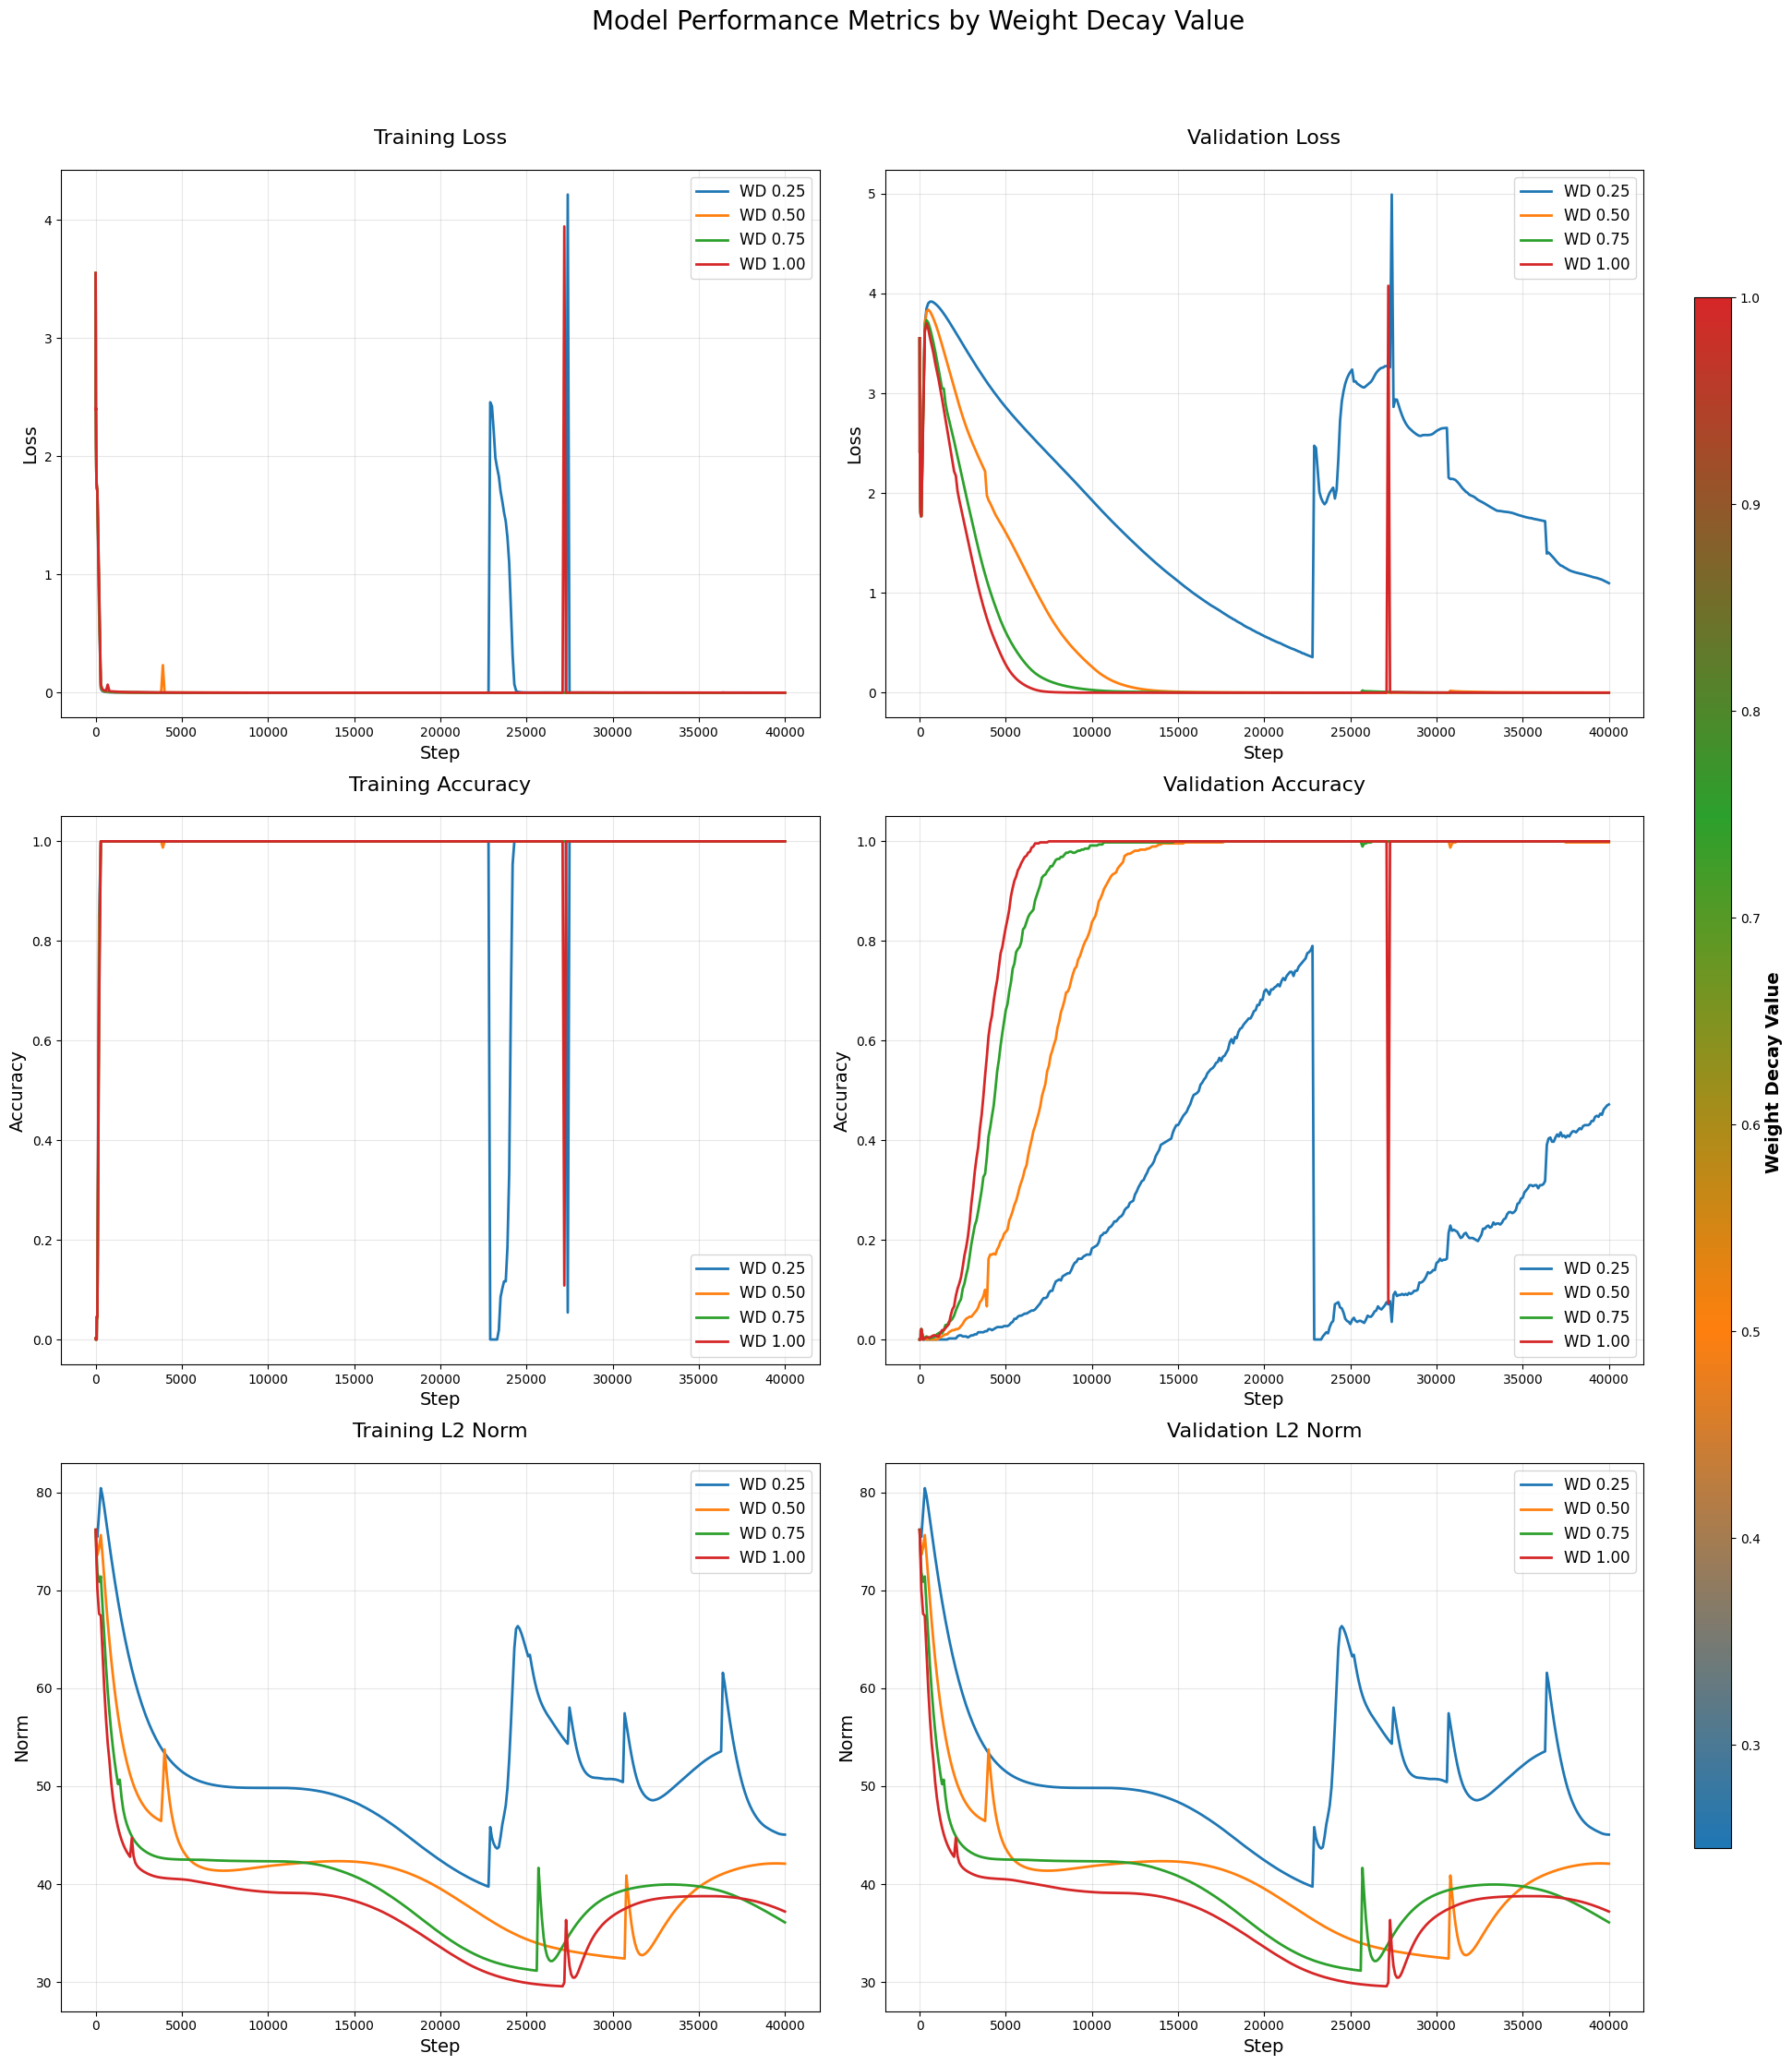

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict
from matplotlib.lines import Line2D

# Base directory containing the logs
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs"

# Weight decay values and their string representations
decay_values = [0.25, 0.5, 0.75, 1.0]
decay_strings = {0.25: "0.25", 0.5: "0.50", 0.75: "0.75", 1.0: "1.00"}

# Initialize dictionaries to store paths and metrics
file_paths = defaultdict(list)
metrics = defaultdict(dict)

def to_np(x):
    """Convert torch.Tensors or lists to numpy arrays"""
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    return x

# Collect all the log file paths
for wd in decay_values:
    # Construct the exact file path pattern
    wd_str = decay_strings[wd]
    file_path = os.path.join(base_dir, f"wd_{wd}", "0", f"wd={wd_str}.pth")

    if os.path.exists(file_path):
        file_paths[wd].append(file_path)
    else:
        print(f"File not found: {file_path}")

# Extract metrics for all found files
for wd, paths in file_paths.items():
    for path in paths:
        try:
            data = torch.load(path, map_location=torch.device('cpu'))

            # Convert all metrics to numpy arrays
            processed_data = {
                'train_loss': to_np(data['train']['loss']),
                'val_loss': to_np(data['test']['loss']),
                'train_acc': to_np(data['train']['accuracy']),
                'val_acc': to_np(data['test']['accuracy']),
                'train_l2': to_np(data['train']['l2_norm']),
                'val_l2': to_np(data['test']['l2_norm']),
                'steps': to_np(data['all_steps'])  # Using all_steps instead of steps_epoch
            }
            metrics[wd] = processed_data
        except Exception as e:
            print(f"Error processing {path}: {e}")

# Create visualization if we found any valid data
if not metrics:
    print("No valid data found to plot!")
else:
    # Create a custom colormap for decay values
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
    cmap = LinearSegmentedColormap.from_list("decay_cmap", colors)
    norm = plt.Normalize(min(decay_values), max(decay_values))

    # Create a 3x2 grid of plots
    fig, axs = plt.subplots(3, 2, figsize=(20, 24))
    plot_titles = [
        'Training Loss', 'Validation Loss',
        'Training Accuracy', 'Validation Accuracy',
        'Training L2 Norm', 'Validation L2 Norm'
    ]
    plot_keys = [
        'train_loss', 'val_loss',
        'train_acc', 'val_acc',
        'train_l2', 'val_l2'
    ]

    # Plot each metric in its respective subplot
    for i, (title, key) in enumerate(zip(plot_titles, plot_keys)):
        row, col = i // 2, i % 2
        ax = axs[row, col]

        for wd, data in metrics.items():
            if data and key in data and len(data[key]) > 0:
                color = cmap(norm(wd))
                steps = data['steps'][:len(data[key])]

                ax.plot(steps, data[key][:len(steps)],
                        color=color,
                        linewidth=2,
                        label=f'WD {wd:.2f}')

        ax.set_title(title, fontsize=16, pad=20)
        ax.set_xlabel('Step', fontsize=14)
        ax.set_ylabel(title.split()[-1], fontsize=14)  # Gets "Loss", "Accuracy", or "Norm"
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=12)

    # # Create custom legend for weight decay values
    # legend_handles = [Line2D([0], [0],
    #                        color=cmap(norm(wd)),
    #                        label=f'WD {wd:.2f}') for wd in decay_values]

    # # Add the legend to the figure
    # fig.legend(handles=legend_handles,
    #            loc='upper center',
    #            bbox_to_anchor=(0.5, 0.05),
    #            ncol=len(decay_values),
    #            fontsize=14)

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Weight Decay Value', fontsize=14, weight='bold')

    # Add main title
    fig.suptitle('Model Performance Metrics by Weight Decay Value', fontsize=20, y=0.98)

    plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])
    plt.show()

In [ ]:
import torch

file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/wd_0.5/0/wd=0.50.pth"

# Load the dictionary
data = processed_data

# Print all top-level keys
print("Top-level keys in the dictionary:")
print("-" * 30)
for key in data.keys():
    print(key)

# If you want to check nested keys (e.g., inside 'train' or 'test')
if 'train' in data:
    print("\nKeys inside 'train':")
    print("-" * 30)
    for key in data['train'].keys():
        print(key)

if 'test' in data:
    print("\nKeys inside 'test':")
    print("-" * 30)
    for key in data['test'].keys():
        print(key)

NameError: name 'processed_data' is not defined

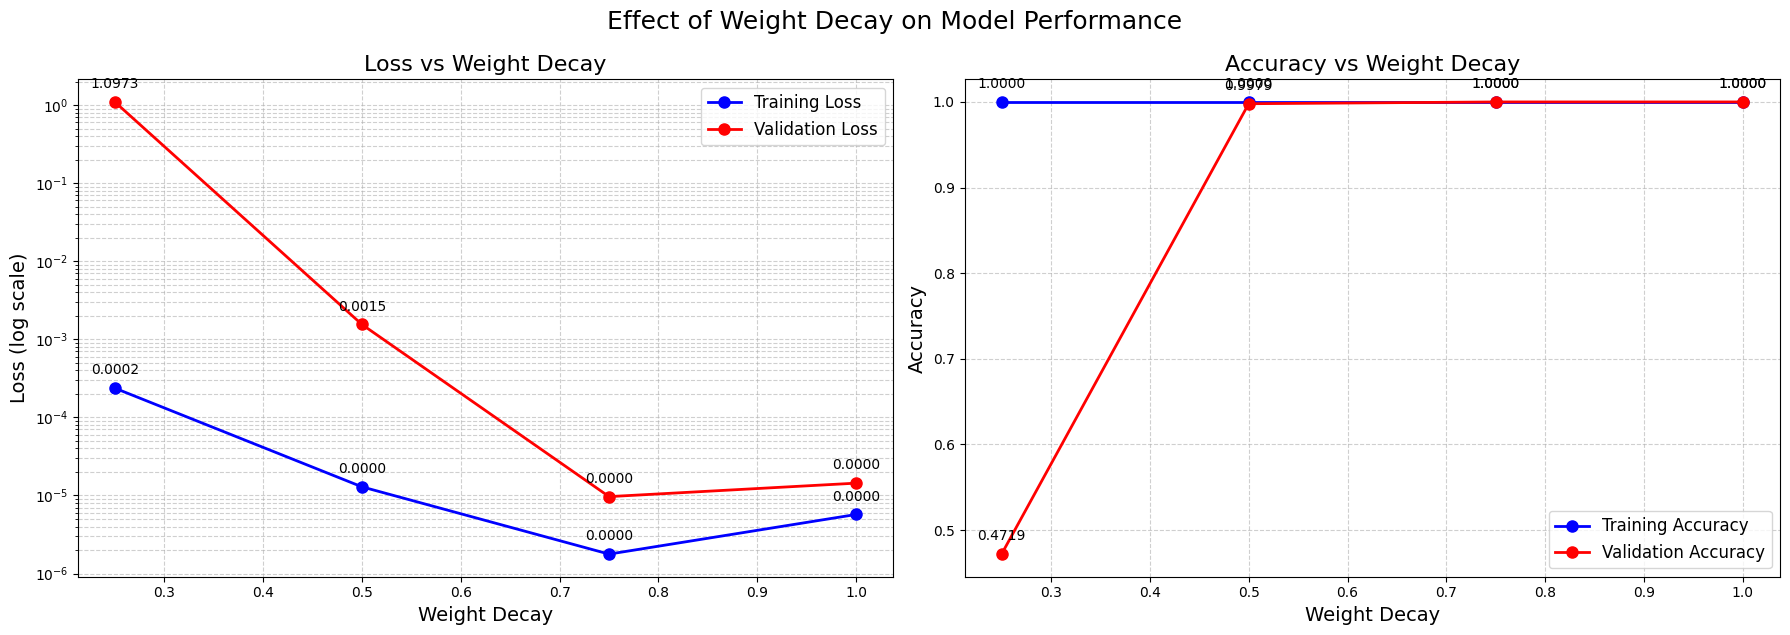

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict

# Base directory containing the logs
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs"

# Weight decay values and their string representations
decay_values = [0.25, 0.5, 0.75, 1.0]
decay_strings = {0.25: "0.25", 0.5: "0.50", 0.75: "0.75", 1.0: "1.00"}

# Initialize dictionaries to store paths and metrics
file_paths = defaultdict(list)
metrics = defaultdict(dict)

def to_np(x):
    """Convert torch.Tensors or lists to numpy arrays"""
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    return x

# Collect all the log file paths
for wd in decay_values:
    # Construct the exact file path pattern
    wd_str = decay_strings[wd]
    file_path = os.path.join(base_dir, f"wd_{wd}", "0", f"wd={wd_str}.pth")

    if os.path.exists(file_path):
        file_paths[wd].append(file_path)
    else:
        print(f"File not found: {file_path}")

# Extract metrics for all found files
for wd, paths in file_paths.items():
    for path in paths:
        try:
            data = torch.load(path, map_location=torch.device('cpu'))

            # Convert all metrics to numpy arrays
            processed_data = {
                'train_loss': to_np(data['train']['loss']),
                'val_loss': to_np(data['test']['loss']),
                'train_acc': to_np(data['train']['accuracy']),
                'val_acc': to_np(data['test']['accuracy']),
                'train_l2': to_np(data['train']['l2_norm']),
                'val_l2': to_np(data['test']['l2_norm']),
                'steps': to_np(data['all_steps'])
            }
            metrics[wd] = processed_data
        except Exception as e:
            print(f"Error processing {path}: {e}")

# Create visualization if we found any valid data
if not metrics:
    print("No valid data found to plot!")
else:
    # Extract final values for each metric at each weight decay
    final_values = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    wd_list = []

    for wd in sorted(metrics.keys()):
        data = metrics[wd]
        wd_list.append(wd)

        for metric in final_values.keys():
            if metric in data and len(data[metric]) > 0:
                # Get the final value for this metric
                final_values[metric].append(data[metric][-1])
            else:
                final_values[metric].append(np.nan)

    # Create a 1x2 grid for side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Loss vs Weight Decay (log scale for y-axis)
    ax1.plot(wd_list, final_values['train_loss'], 'o-', color='blue', linewidth=2, markersize=8, label='Training Loss')
    ax1.plot(wd_list, final_values['val_loss'], 'o-', color='red', linewidth=2, markersize=8, label='Validation Loss')
    ax1.set_title('Loss vs Weight Decay', fontsize=16)
    ax1.set_xlabel('Weight Decay', fontsize=14)
    ax1.set_ylabel('Loss (log scale)', fontsize=14)
    ax1.set_yscale('log')  # Set log scale for y-axis
    ax1.grid(True, which="both", linestyle='--', alpha=0.6)
    ax1.legend(fontsize=12)

    # Add value labels to the loss plot
    for i, wd in enumerate(wd_list):
        ax1.annotate(f'{final_values["train_loss"][i]:.4f}',
                    (wd, final_values['train_loss'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')
        ax1.annotate(f'{final_values["val_loss"][i]:.4f}',
                    (wd, final_values['val_loss'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    # Plot 2: Accuracy vs Weight Decay
    ax2.plot(wd_list, final_values['train_acc'], 'o-', color='blue', linewidth=2, markersize=8, label='Training Accuracy')
    ax2.plot(wd_list, final_values['val_acc'], 'o-', color='red', linewidth=2, markersize=8, label='Validation Accuracy')
    ax2.set_title('Accuracy vs Weight Decay', fontsize=16)
    ax2.set_xlabel('Weight Decay', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(fontsize=12)

    # Add value labels to the accuracy plot
    for i, wd in enumerate(wd_list):
        ax2.annotate(f'{final_values["train_acc"][i]:.4f}',
                    (wd, final_values['train_acc'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')
        ax2.annotate(f'{final_values["val_acc"][i]:.4f}',
                    (wd, final_values['val_acc'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    # Adjust layout and add main title
    plt.tight_layout()
    fig.suptitle('Effect of Weight Decay on Model Performance', fontsize=18, y=1.05)

    # Show the plot
    plt.show()

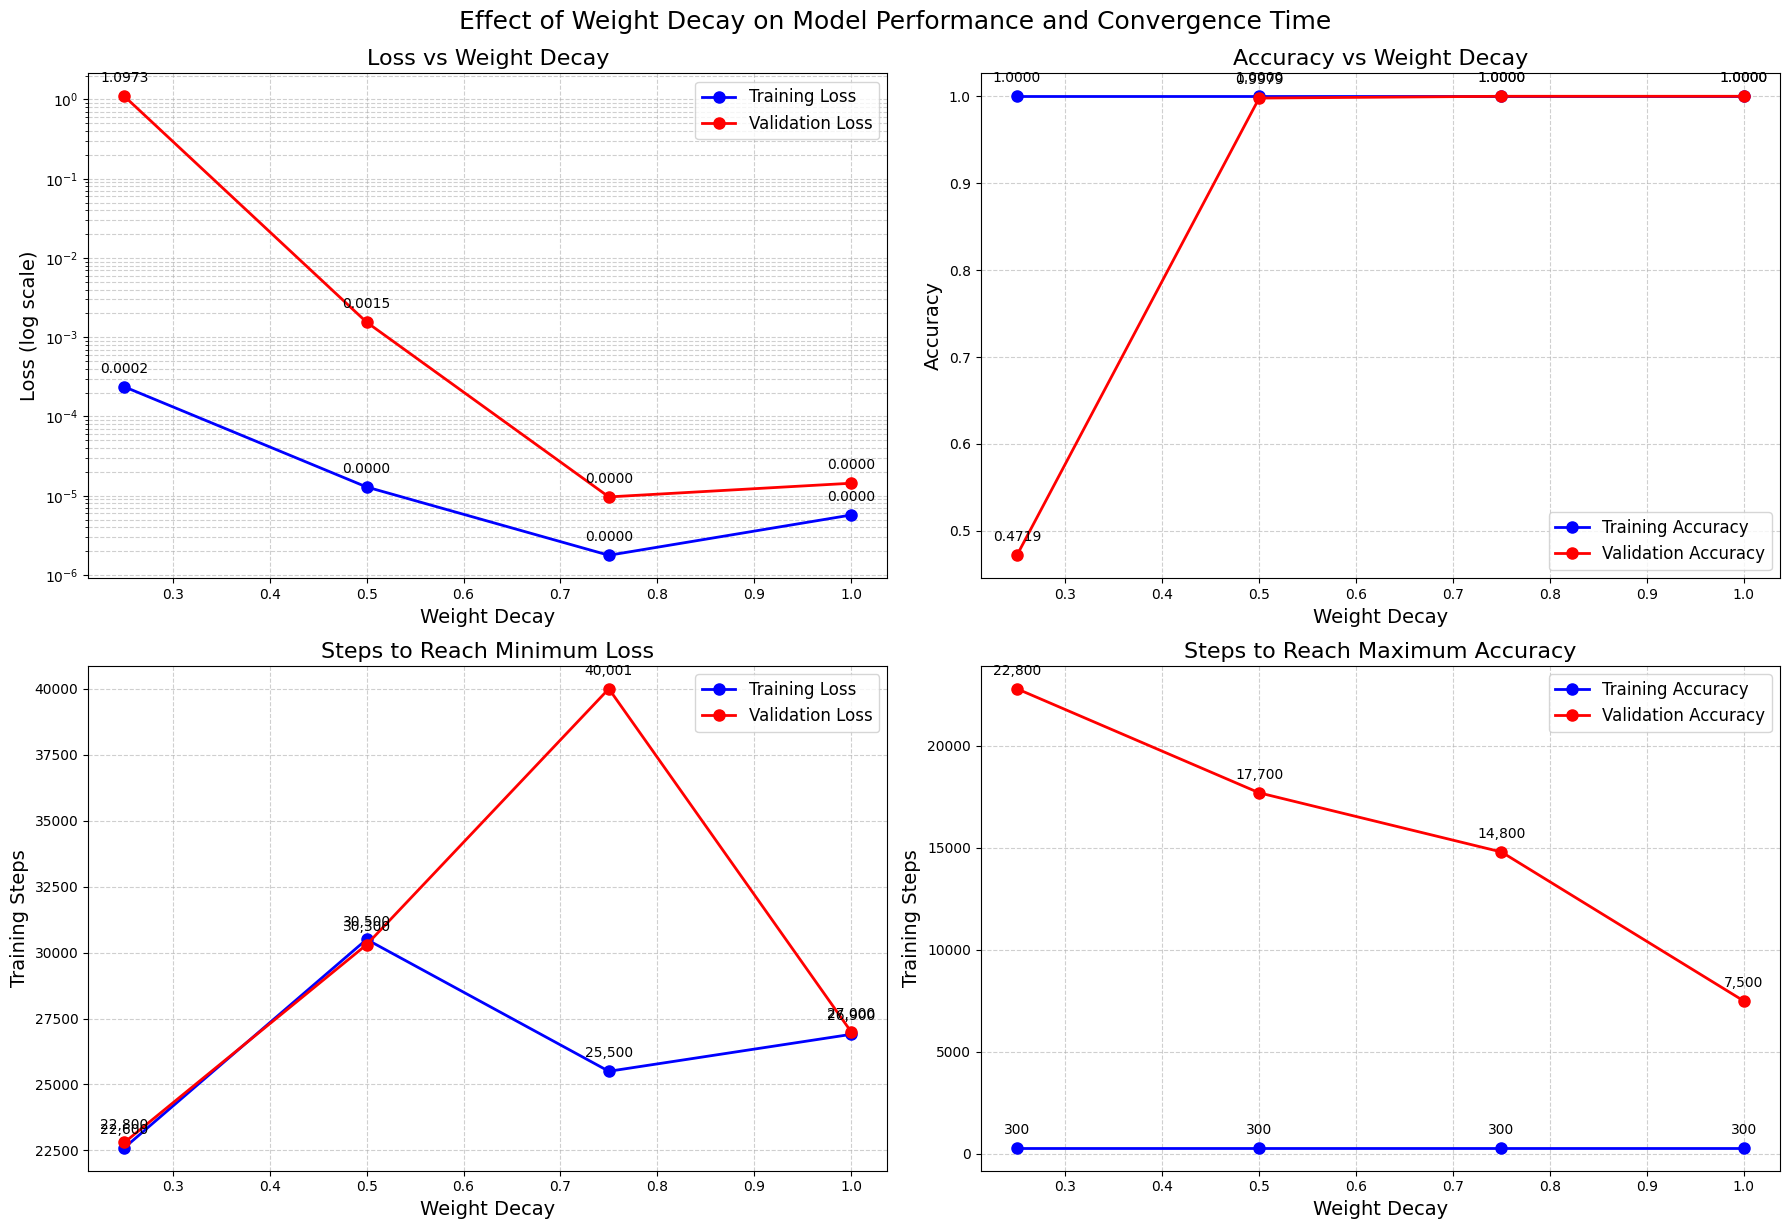

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict

# Base directory containing the logs
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs"

# Weight decay values and their string representations
decay_values = [0.25, 0.5, 0.75, 1.0]
decay_strings = {0.25: "0.25", 0.5: "0.50", 0.75: "0.75", 1.0: "1.00"}

# Initialize dictionaries to store paths and metrics
file_paths = defaultdict(list)
metrics = defaultdict(dict)

def to_np(x):
    """Convert torch.Tensors or lists to numpy arrays"""
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    return x

# Collect all the log file paths
for wd in decay_values:
    # Construct the exact file path pattern
    wd_str = decay_strings[wd]
    file_path = os.path.join(base_dir, f"wd_{wd}", "0", f"wd={wd_str}.pth")

    if os.path.exists(file_path):
        file_paths[wd].append(file_path)
    else:
        print(f"File not found: {file_path}")

# Extract metrics for all found files
for wd, paths in file_paths.items():
    for path in paths:
        try:
            data = torch.load(path, map_location=torch.device('cpu'))

            # Convert all metrics to numpy arrays
            processed_data = {
                'train_loss': to_np(data['train']['loss']),
                'val_loss': to_np(data['test']['loss']),
                'train_acc': to_np(data['train']['accuracy']),
                'val_acc': to_np(data['test']['accuracy']),
                'train_l2': to_np(data['train']['l2_norm']),
                'val_l2': to_np(data['test']['l2_norm']),
                'steps': to_np(data['all_steps'])
            }
            metrics[wd] = processed_data
        except Exception as e:
            print(f"Error processing {path}: {e}")

# Create visualization if we found any valid data
if not metrics:
    print("No valid data found to plot!")
else:
    # Extract final values and time to reach optimal values for each metric at each weight decay
    final_values = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'time_to_min_train_loss': [],
        'time_to_min_val_loss': [],
        'time_to_max_train_acc': [],
        'time_to_max_val_acc': []
    }

    wd_list = []

    for wd in sorted(metrics.keys()):
        data = metrics[wd]
        wd_list.append(wd)

        # Final values
        for metric in ['train_loss', 'val_loss', 'train_acc', 'val_acc']:
            if metric in data and len(data[metric]) > 0:
                final_values[metric].append(data[metric][-1])
            else:
                final_values[metric].append(np.nan)

        # Time to min training loss
        if 'train_loss' in data and 'steps' in data:
            min_loss_idx = np.argmin(data['train_loss'])
            final_values['time_to_min_train_loss'].append(data['steps'][min_loss_idx])
        else:
            final_values['time_to_min_train_loss'].append(np.nan)

        # Time to min validation loss
        if 'val_loss' in data and 'steps' in data:
            min_loss_idx = np.argmin(data['val_loss'])
            final_values['time_to_min_val_loss'].append(data['steps'][min_loss_idx])
        else:
            final_values['time_to_min_val_loss'].append(np.nan)

        # Time to max training accuracy
        if 'train_acc' in data and 'steps' in data:
            max_acc_idx = np.argmax(data['train_acc'])
            final_values['time_to_max_train_acc'].append(data['steps'][max_acc_idx])
        else:
            final_values['time_to_max_train_acc'].append(np.nan)

        # Time to max validation accuracy
        if 'val_acc' in data and 'steps' in data:
            max_acc_idx = np.argmax(data['val_acc'])
            final_values['time_to_max_val_acc'].append(data['steps'][max_acc_idx])
        else:
            final_values['time_to_max_val_acc'].append(np.nan)

    # Create a 2x2 grid for plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

    # Plot 1: Loss vs Weight Decay (log scale for y-axis)
    ax1.plot(wd_list, final_values['train_loss'], 'o-', color='blue', linewidth=2, markersize=8, label='Training Loss')
    ax1.plot(wd_list, final_values['val_loss'], 'o-', color='red', linewidth=2, markersize=8, label='Validation Loss')
    ax1.set_title('Loss vs Weight Decay', fontsize=16)
    ax1.set_xlabel('Weight Decay', fontsize=14)
    ax1.set_ylabel('Loss (log scale)', fontsize=14)
    ax1.set_yscale('log')  # Set log scale for y-axis
    ax1.grid(True, which="both", linestyle='--', alpha=0.6)
    ax1.legend(fontsize=12)

    # Add value labels to the loss plot
    for i, wd in enumerate(wd_list):
        ax1.annotate(f'{final_values["train_loss"][i]:.4f}',
                    (wd, final_values['train_loss'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')
        ax1.annotate(f'{final_values["val_loss"][i]:.4f}',
                    (wd, final_values['val_loss'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    # Plot 2: Accuracy vs Weight Decay
    ax2.plot(wd_list, final_values['train_acc'], 'o-', color='blue', linewidth=2, markersize=8, label='Training Accuracy')
    ax2.plot(wd_list, final_values['val_acc'], 'o-', color='red', linewidth=2, markersize=8, label='Validation Accuracy')
    ax2.set_title('Accuracy vs Weight Decay', fontsize=16)
    ax2.set_xlabel('Weight Decay', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(fontsize=12)

    # Add value labels to the accuracy plot
    for i, wd in enumerate(wd_list):
        ax2.annotate(f'{final_values["train_acc"][i]:.4f}',
                    (wd, final_values['train_acc'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')
        ax2.annotate(f'{final_values["val_acc"][i]:.4f}',
                    (wd, final_values['val_acc'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    # Plot 3: Time to minimum loss (both train and val)
    ax3.plot(wd_list, final_values['time_to_min_train_loss'], 'o-', color='blue', linewidth=2, markersize=8, label='Training Loss')
    ax3.plot(wd_list, final_values['time_to_min_val_loss'], 'o-', color='red', linewidth=2, markersize=8, label='Validation Loss')
    ax3.set_title('Steps to Reach Minimum Loss', fontsize=16)
    ax3.set_xlabel('Weight Decay', fontsize=14)
    ax3.set_ylabel('Training Steps', fontsize=14)
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.legend(fontsize=12)

    # Add value labels to the steps plot
    for i, wd in enumerate(wd_list):
        ax3.annotate(f'{final_values["time_to_min_train_loss"][i]:,.0f}',
                    (wd, final_values['time_to_min_train_loss'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')
        ax3.annotate(f'{final_values["time_to_min_val_loss"][i]:,.0f}',
                    (wd, final_values['time_to_min_val_loss'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    # Plot 4: Time to maximum accuracy (both train and val)
    ax4.plot(wd_list, final_values['time_to_max_train_acc'], 'o-', color='blue', linewidth=2, markersize=8, label='Training Accuracy')
    ax4.plot(wd_list, final_values['time_to_max_val_acc'], 'o-', color='red', linewidth=2, markersize=8, label='Validation Accuracy')
    ax4.set_title('Steps to Reach Maximum Accuracy', fontsize=16)
    ax4.set_xlabel('Weight Decay', fontsize=14)
    ax4.set_ylabel('Training Steps', fontsize=14)
    ax4.grid(True, linestyle='--', alpha=0.6)
    ax4.legend(fontsize=12)

    # Add value labels to the steps plot
    for i, wd in enumerate(wd_list):
        ax4.annotate(f'{final_values["time_to_max_train_acc"][i]:,.0f}',
                    (wd, final_values['time_to_max_train_acc'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')
        ax4.annotate(f'{final_values["time_to_max_val_acc"][i]:,.0f}',
                    (wd, final_values['time_to_max_val_acc'][i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    # Adjust layout and add main title
    plt.tight_layout()
    fig.suptitle('Effect of Weight Decay on Model Performance and Convergence Time', fontsize=18, y=1.02)

    # Show the plot
    plt.show()